# A Trustworthy Model for Loan Eligibility Assessment

The focus of this project being interpretability, we won't invest a lot of time in preprocessing and optimization.

In [32]:
import sys
sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# Interpretability
from src.interpretation.utils import plot_dependence
from sklearn.inspection import PartialDependenceDisplay
import shap
shap.initjs()            # enable shap.force_plot()

from joblib import load

# Set transformers output to Pandas DataFrame instead of NumPy array
from sklearn import set_config
set_config(transform_output="pandas")

## Loading data, preprocessing pipeline and model

**Loading data**

In [33]:
X_test = pd.read_csv('../data/raw/loan-data-test.csv')
print(f'X_test shape: {X_test.shape}')
X_test.head()

X_test shape: (367, 12)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


**Dropping sensitive features**

In [34]:
X_test.drop(columns=['Loan_ID', 'Married', 'Education'], inplace=True)

**Loading preprocessing pipeline and model**

In [35]:
with open('../models/model.pkl', 'rb') as f:
    model = load(f)

with open('../models/preprocessor.pkl', 'rb') as f:
    preprocessor = load(f)

## Preprocessing

In [36]:
# Mapping number of dependents to numerical values
X_test.Dependents.replace('3+', 3, inplace=True)

# Transforming the test set
X_test = preprocessor.transform(X_test)

## Model's coefficients

Without surprise, the credit history has the most important on the model's predictions. Indeed, no credit history means rejection is guaranteed.

In [37]:
coef_df = pd.DataFrame(model.coef_[0], model.feature_names_in_)
coef_df["Abs"] = coef_df[0].abs()
coef_df.sort_values(by="Abs", ascending=False, inplace=True)
coef_df.drop("Abs", axis=1, inplace=True)
coef_df

,0
Credit_History_1.0,3.121894
Property_Area_Semiurban,0.444134
Property_Area_Rural,-0.362553
CoapplicantIncome,0.293695
Self_Employed_Yes,-0.191845
LoanAmount,-0.163539
ApplicantIncome,0.161034
Dependents,0.095625
Loan_Amount_Term,-0.088266
Property_Area_Urban,-0.080985


## Explaining the model with SHAP

How does the model learn? Let's open the box.

### Mapping the Data to its Original Scale

The data was scaled to train the model but we want to visualize the explanations with the original values.

Based on the property that *any univariate transformation applied to a model’s inputs does not effect the Shapley values for the model*, we can replace the scaled value in the model explainer by the original values.

See [shap documentation](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/linear_models/Explaining%20a%20model%20that%20uses%20standardized%20features.html).

In [38]:
# Get the scaler and encoder object from the pipeline
scaler = preprocessor.named_transformers_['numerical']['scaler']
encoder = preprocessor.named_transformers_['categorical']['onehot']

# Unscale the  data 
X_test_num_unscaled = scaler.inverse_transform(X_test[scaler.feature_names_in_])
X_test_num_unscaled_df = pd.DataFrame(data=X_test_num_unscaled, columns=scaler.feature_names_in_)

# Get the one-hot encoded features
X_test_cat = X_test[encoder.get_feature_names_out()]

# # Get the engineered features
# X_test_eng = X_test[['Total_Income', 'Amount_Income_Ratio_Percent']]

# Reset the index before concatenation
X_test_num_unscaled_df.reset_index(drop=True, inplace=True)
X_test_cat.reset_index(drop=True, inplace=True)

# Concat the unscaled numeric data and the categorical data
# X_test_unscaled = pd.concat([X_test_num_unscaled_df, X_test_cat, X_test_eng], axis=1)
X_test_unscaled = pd.concat([X_test_num_unscaled_df, X_test_cat], axis=1)
X_test_unscaled.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Male,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Credit_History_1.0
0,0.0,5720.0,0.0,110.0,360.0,1.0,0.0,0.0,0.0,1.0,1.0
1,1.0,3076.0,1500.0,126.0,360.0,1.0,0.0,0.0,0.0,1.0,1.0
2,2.0,5000.0,1800.0,208.0,360.0,1.0,0.0,0.0,0.0,1.0,1.0
3,2.0,2340.0,2546.0,100.0,360.0,1.0,0.0,0.0,0.0,1.0,1.0
4,0.0,3276.0,0.0,78.0,360.0,1.0,0.0,0.0,0.0,1.0,1.0


### Creating a shap explainer

In [39]:
X_test.shape, X_test_unscaled.shape

((367, 11), (367, 11))

In [40]:
explainer = shap.LinearExplainer(model, X_test)
shap_explanation = explainer(X_test)

# Replace the scaled values by the original ones
shap_explanation.data = X_test_unscaled.values

### Explain Global Predictions

How does the model make predictions overall?

This plot below is simple yet powerful. Here is how to interpret it:

#### Blue VS Red

- Colors close to red indicate high values
- Colors close to blue indicate small values

#### Approval VS Rejection

On the X-axis are the SHAP values separated at 0 by a vertical line. SHAP values greater than 0 push the prediction towards the positive class (approval), while the one lower than 0 push the prediction towards the negative class (rejection):

- Points on the left of the vertical line have SHAP values lower than 0. They negatively impact approval (positive class)
- Points on the right of the vertical line have SHAP values greater than 0. They postively impact the approval.


In other words, if a point is after the vertical line, it moves the prediction towards the positive class (Approval).
If this point is blue, it indicates that its value is low. 

Look at the plot below, in the case of "Loan amount", we can observe that higher values move the prediction towards the negative class (rejection). In fact, the higher the loan amount, the less likely it is to be approved.
It is good to see that the Gender has no effect on the prediction.

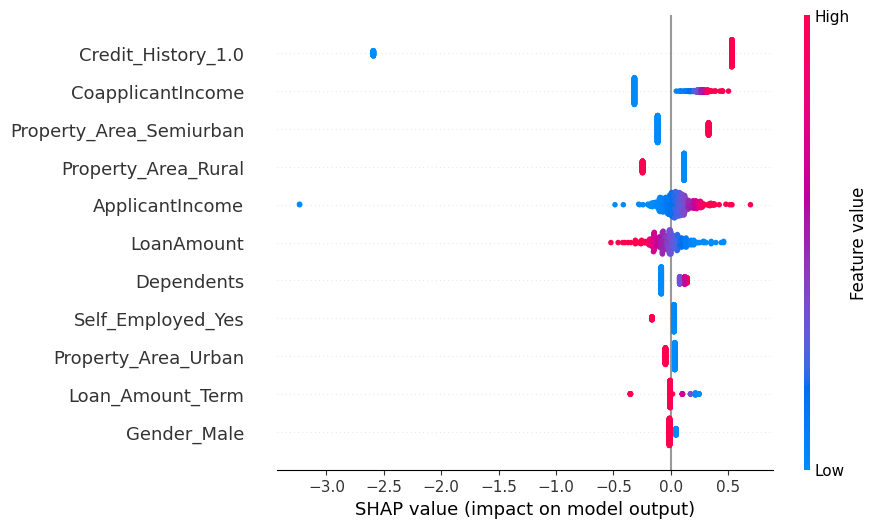

In [41]:
shap.plots.beeswarm(shap_explanation, max_display=100)

#### Explaining numeric features

It is counterintuitive to see that higher the co-applicant income leads to lower probability of being approved. 

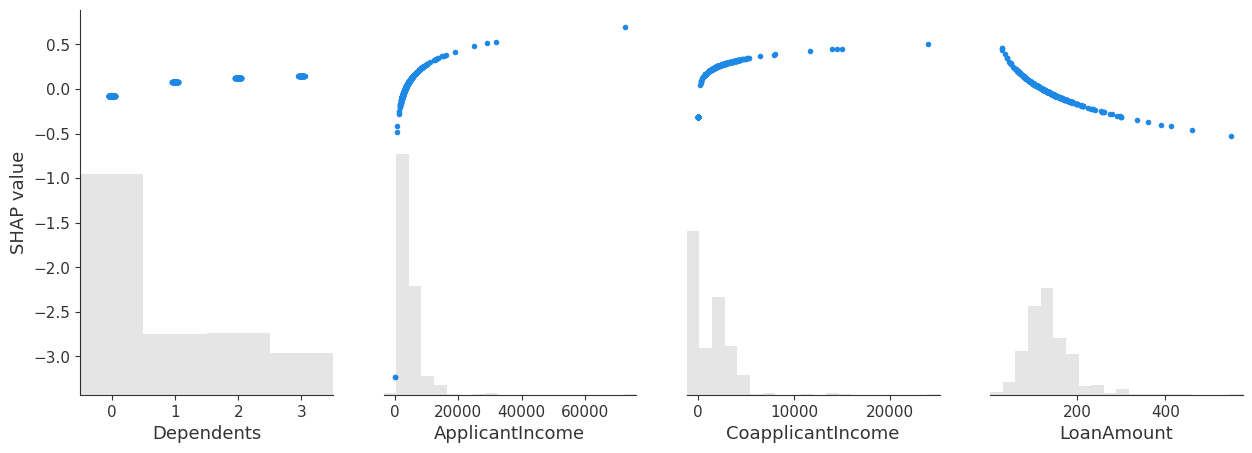

In [53]:
shap.plots.scatter(shap_explanation[:, 0:4])

### Explaining a single prediction

Let's examine the data of the first applicant. 

We can see that they have been approved and here is how the model sees things: 

- The applicant has a credit history, which is the most important factor for approval
- The applicant is married, which could indicate more stability
- The applicant is not graduate, which is at the same time surprising and interesting!
- The applicant has a good income

We can also see that the non-existing co-applicant income reduced the probability of approval.

In [43]:
X_test[
    (model.predict(X_test) == 0) &
    (X_test['Credit_History_1.0'] == 1)
]

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Male,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Credit_History_1.0
38,-0.827104,0.540189,-1.102837,-0.218291,0.175540,1.0,1.0,0.0,0.0,1.0,1.0
54,-0.827104,0.392553,-1.102837,-0.681905,0.175540,1.0,1.0,0.0,0.0,1.0,1.0
56,-0.827104,0.108403,-1.102837,0.011789,0.175540,0.0,0.0,1.0,0.0,0.0,1.0
73,-0.827104,-0.081157,0.853840,1.203093,0.175540,1.0,1.0,1.0,0.0,0.0,1.0
77,-0.827104,0.669482,-1.102837,-1.871835,0.175540,1.0,1.0,1.0,0.0,0.0,1.0
83,-0.827104,1.090129,-1.102837,1.417311,0.175540,1.0,0.0,1.0,0.0,0.0,1.0
89,-0.827104,0.323036,-1.102837,0.894394,0.175540,0.0,0.0,1.0,0.0,0.0,1.0
91,1.522278,1.758634,-1.102837,2.301786,0.175540,1.0,0.0,1.0,0.0,0.0,1.0
100,-0.827104,0.125967,-1.102837,0.027313,0.175540,1.0,0.0,1.0,0.0,0.0,1.0
107,1.522278,0.147104,-1.102837,-0.149985,0.175540,1.0,0.0,1.0,0.0,0.0,1.0


Approved


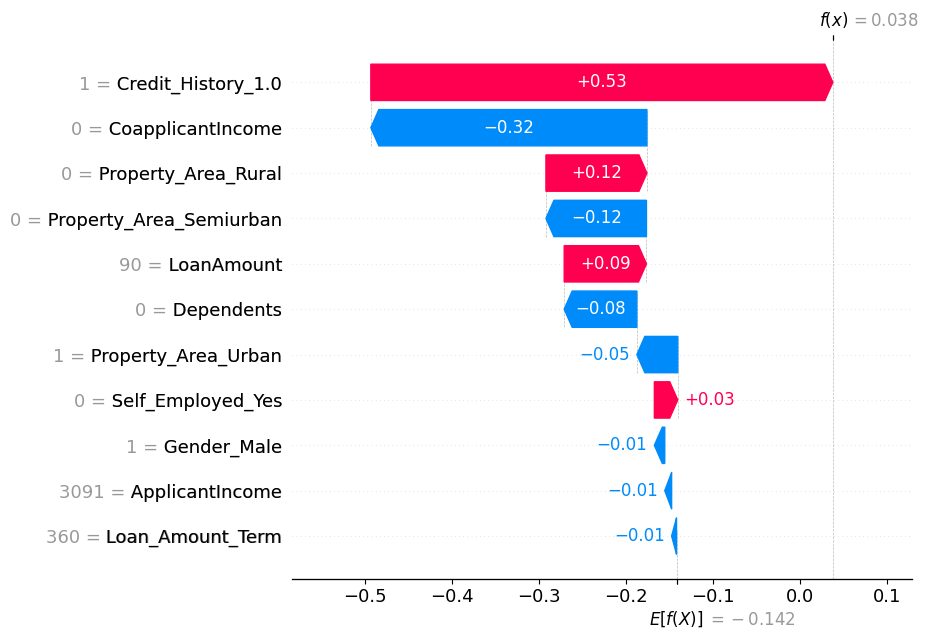

In [44]:
# print('Approved' if y_test[0]==1 else 'Rejected')
i = 10 # 88
pred = model.predict(X_test.iloc[[i]])
print('Approved' if pred == 1 else 'Rejected')

shap.plots.waterfall(shap_explanation[i], max_display=70)

In [45]:
shap.force_plot(shap_explanation[i])

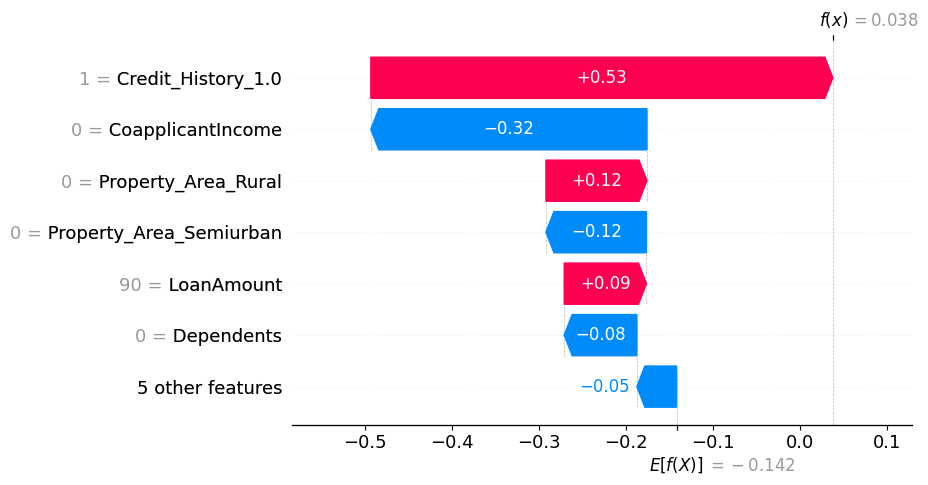

In [46]:
shap.plots.waterfall(shap_explanation[i], max_display=7)

## Explaining the model with Partial Dependence and ICE

In [47]:
X_test.columns

Index(['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Gender_Male', 'Self_Employed_Yes',
       'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban',
       'Credit_History_1.0'],
      dtype='object')

In [48]:
X_test_unscaled.iloc[0]

Dependents                    0.0
ApplicantIncome            5720.0
CoapplicantIncome             0.0
LoanAmount                  110.0
Loan_Amount_Term            360.0
Gender_Male                   1.0
Self_Employed_Yes             0.0
Property_Area_Rural           0.0
Property_Area_Semiurban       0.0
Property_Area_Urban           1.0
Credit_History_1.0            1.0
Name: 0, dtype: float64

In [49]:
shap_explanation[0]

.values =
array([-0.083,  0.147, -0.317,  0.029, -0.006, -0.012,  0.027,  0.116,
       -0.115, -0.047,  0.531])

.base_values =
-0.1420230761136736

.data =
array([   0., 5720.,    0.,  110.,  360.,    1.,    0.,    0.,    0.,
          1.,    1.])

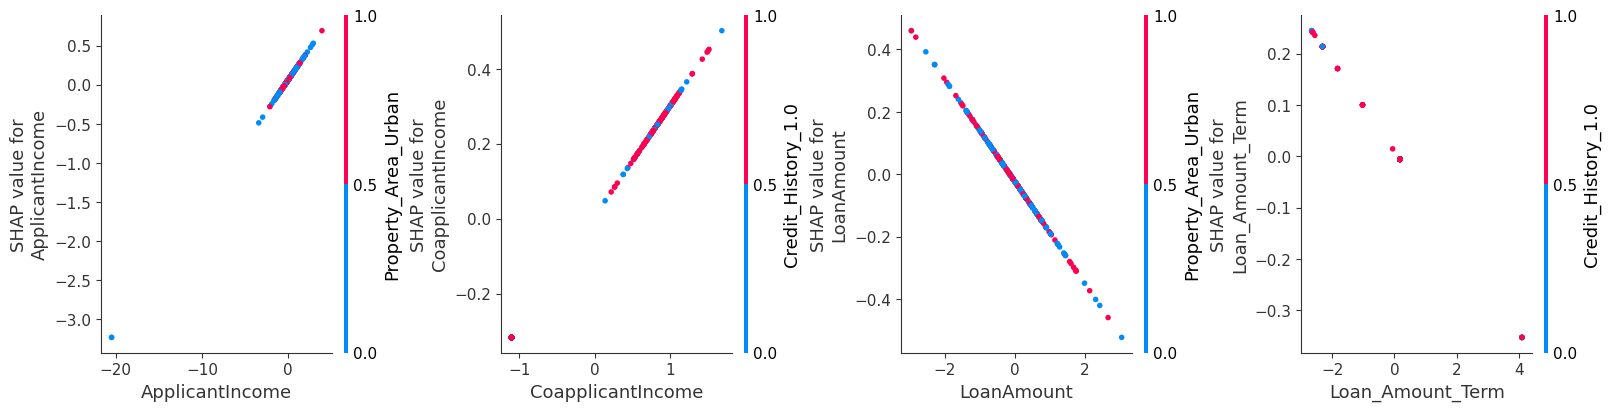

In [50]:
num_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
plot_dependence(features=num_features, shap_values=shap_explanation.values, data=X_test, plot_shape=(4, 1), figsize=(16, 4))

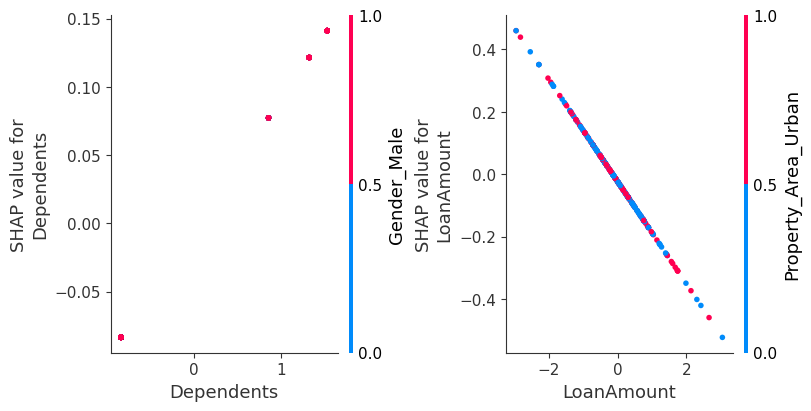

In [51]:
plot_dependence(features=['Dependents', 'LoanAmount'], shap_values=shap_explanation.values, data=X_test, plot_shape=(2, 1), figsize=(8, 4))

#### Conclusion

From the shap plots, we can conclude that:

Higher applicant income (and co-applicant income) increases the probability of being approved.
A high loan amount decreases the probability of being approved. The same applies to the loan amount term.

### Feature Interaction

In [52]:
# features = X_test.columns
# feature_pair1 = (features[0], features[1])
# feature_pair2 = (features[1], features[2])
# feature_pair3 = (features[0], features[2])
# feature_pairs = [feature_pair1, feature_pair2, feature_pair3]

# pdp_plot(
#     model, 
#     data=X_test, features=feature_pairs, 
#     plot_shape=(3, 1), figsize=(12, 4)
# )